# Задача

Попробуйте улучшить точность распознавания образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложите анализ с описанием того, что улучшает работу нейронной сети, а что ухудшает

In [11]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Поработаем с регуляризацией, используя Dropout
предназначенная для уменьшения переобучения сети за счет предотвращения сложных адаптаций отдельных нейронов на тренировочных данных во время обучения.


In [12]:
Dropout(rate=0.5)

In [13]:
Sequential([
    BatchNormalization(input_shape=(8, 8, 2))
]).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 8, 8, 2)          8         
 hNormalization)                                                 
                                                                 
Total params: 8
Trainable params: 4
Non-trainable params: 4
_________________________________________________________________


In [14]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [15]:
# установка параметров нейросети
batch_size = 512
num_classes = 10
epochs = 5
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


X_train = X_train / 255.0
X_test = X_test / 255.0

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


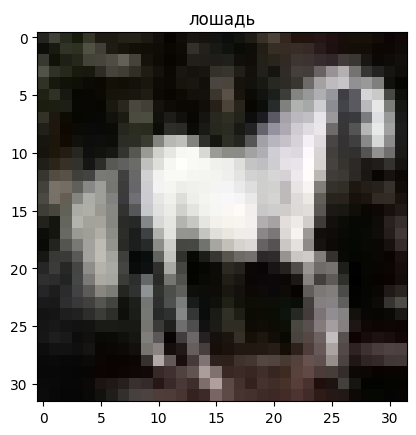

In [16]:
N = 13

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

In [17]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 32)        0         
                                                      

Будем использовать аугментацию, процедура позволяющая за счёт искажений изображений увеличить количество тренировочных данных

In [18]:
data_augmentation = True

In [19]:
if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=10, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0.2, 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)


    train_gen = datagen.flow(X_train, 
                             y_train,
                             batch_size=batch_size)

    # запуск data augmentation через fit_generator
    model.fit(train_gen,
              epochs=epochs,
              validation_data=(X_test, y_test))

Использование data augmentation
Epoch 1/5
98/98 [==============================] - 30s 276ms/step - loss: 1.8468 - accuracy: 0.3240 - val_loss: 1.4726 - val_accuracy: 0.4602
Epoch 2/5
98/98 [==============================] - 29s 290ms/step - loss: 1.5369 - accuracy: 0.4413 - val_loss: 1.3495 - val_accuracy: 0.5090
Epoch 3/5
98/98 [==============================] - 27s 272ms/step - loss: 1.4127 - accuracy: 0.4913 - val_loss: 1.2400 - val_accuracy: 0.5593
Epoch 4/5
98/98 [==============================] - 27s 273ms/step - loss: 1.2985 - accuracy: 0.5350 - val_loss: 1.1961 - val_accuracy: 0.5763
Epoch 5/5
98/98 [==============================] - 27s 277ms/step - loss: 1.2198 - accuracy: 0.5656 - val_loss: 1.0516 - val_accuracy: 0.6294


In [20]:
# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print(f'Сохранить обученную модель как {model_path}')

# проверка работы обученной модели
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Сохранить обученную модель как /content/saved_models/keras_cifar10_trained_model.h5
313/313 [==============================] - 1s 3ms/step - loss: 1.0516 - accuracy: 0.6294
Test loss: 1.0516408681869507
Test accuracy: 0.6294000148773193
